In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from paretoset import paretoset

import model_functions as fmodel

# Matrix ISA Model Example Usage

### Number of Registers to Hide Memory Latency

using larger memories with higher latency requires more matrix registers to acheive high utilization. below is a plot showing how utilization is affected by memory latency for different matrix register counts.

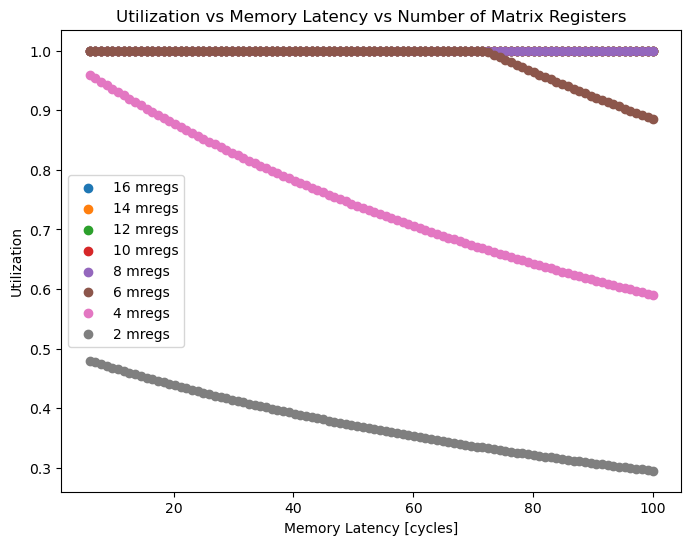

In [2]:
fig, axs = plt.subplots(figsize=(8,6))
axs.set_title('Utilization vs Memory Latency vs Number of Matrix Registers')
axs.set_xlabel('Memory Latency [cycles]')
axs.set_ylabel('Utilization')

level = 1
databits = np.array([32])
slice_values = np.linspace(6, 100, 100)
num_mregs = np.array(range(16, 0, -2))
for n in num_mregs:
    perf_model = fmodel.init_pm(databits, t_mem=slice_values, num_mregs=np.array([n]))

    x = perf_model.index.levels[level]
    y = perf_model['util']
    scatter = axs.scatter(x, y, label=f'{n} mregs')
    axs.legend()

### Exploring Design Space

The model can be used to sweep ranges of the input parameters, and the output performance specs can be visualized using pareto-optimal curves.

With these plots we can visualize the tradeoffs between ngates capacity, memory bandwidth, and performance (operations per cycle).

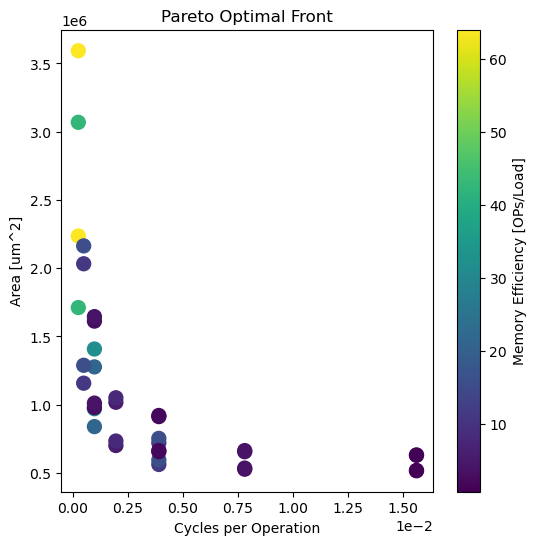

In [5]:
perf_model = fmodel.init_pm(
    vlB = np.array([128, 256, 512])/8,
    kl = np.array([1, 2, 4]),
    N = np.array([128]),
    M = np.array([128]),
    K = np.array([128]),
    num_mregs = np.array(range(2,6,2)),
    t_op = np.array([0]),
    width_datapath = np.array([0.5, 1])
)
# perf_model = perf_model[perf_model['mrf_opi'] <= 64]
# perf_model = perf_model[perf_model['ops_cycle'] >= 1/4e-2]

opi = perf_model['mrf_opi']
opu_area = perf_model['opu_area']
opc = perf_model['ops_cycle']

fig, axs = plt.subplots(1,figsize=(6,6))
axs.set_title('Pareto Optimal Front')
axs.set_xlabel('Cycles per Operation')
axs.set_ylabel('Area [um^2]')

scatter = axs.scatter(1/opc, opu_area, c=opi, cmap='viridis', s=100)
axs.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
fig.colorbar(scatter, ax=axs, label='Memory Efficiency [OPs/Load]')
perf_model


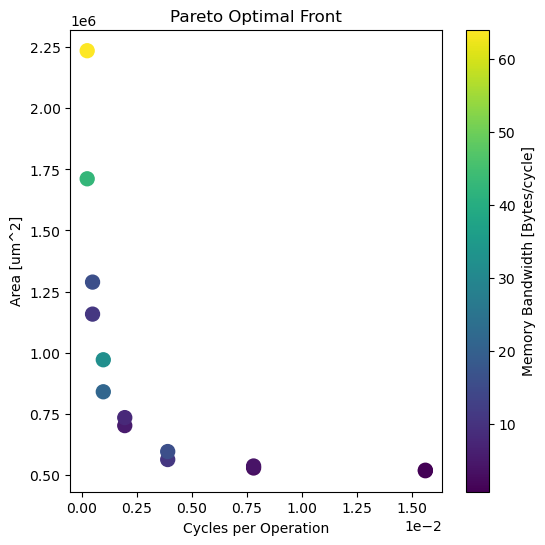

In [6]:

pm_pareto = perf_model[['ops_cycle','opu_area', 'mrf_opi']]
mask = paretoset(pm_pareto, sense=['max', 'min', 'max'])

opi = perf_model.loc[mask, 'mrf_opi']
opu_area = perf_model.loc[mask, 'opu_area']
opc = perf_model.loc[mask, 'ops_cycle']

fig, axs = plt.subplots(1,figsize=(6,6))
axs.set_title('Pareto Optimal Front')
axs.set_xlabel('Cycles per Operation')
axs.set_ylabel('Area [um^2]')

scatter = axs.scatter(1/opc, opu_area, c=opi, cmap='viridis', s=100)
axs.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
fig.colorbar(scatter, ax=axs, label='Memory Efficiency [OPs/Load]')
perf_model

### Comparing Vector Unit with Outer Product Unit

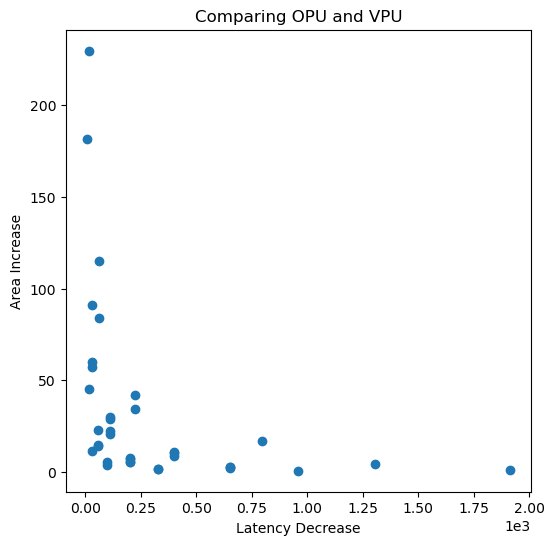

In [22]:
dims = np.array([8, 56])

for i, dim in enumerate(dims):
    perf_model = fmodel.init_pm(
                            vlB=np.array([128, 256, 512])/8,
                            vl_ml=np.array([1, 2]),
                            kl=np.array([1,2,4]),
                            width_datapath=np.array([1/2, 1]),
                            M=np.array([dim]),
                            N=np.array([dim]),
                            K=np.array([dim])
                            )
        
# pm_pareto = perf_model[['speedup_vec','util']]
# mask = paretoset(pm_pareto, sense=['min', 'min'])
# speedup_vec = perf_model.loc[mask,'speedup_vec']
speedup_vec = perf_model['speedup_vec']
increase_area = perf_model['vpu_area']/perf_model['mrf_area']

fig, axs = plt.subplots(1,figsize=(6,6))
axs.set_title('Comparing OPU and VPU')
axs.set_xlabel('Latency Decrease')
axs.set_ylabel('Area Increase')

scatter = axs.scatter(speedup_vec, increase_area)
axs.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# perf_model

#### Memory System

Higher memory latency shifts pareto optimal curve

t_uk  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath          
8        200   64 64 64 256      1  16.0 1     4         0    4     1               496.0   
                                               6         0    4     1               496.0   
                                         2     2         0    4     1               480.0   
                                               4         0    4     1               480.0   
                                               6         0    4     1               480.0   
                                    32.0 1     4         0    4     1               528.0   
                                               6         0    4     1               528.0   
                                         2     4         0    4     1               496.0   
                                               6         0    4     1               496.0   
                                    64.0 1     2         0    4     1               592.0   
                                               4         0    4     1               592.0   
                                         2     4         0    4     1               528.0   
                                               6         0    4     1               528.0   

                                                                                        util  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath             
8        200   64 64 64 256      1  16.0 1     4         0    4     1               0.774194   
                                               6         0    4     1               1.000000   
                                         2     2         0    4     1               0.333333   
                                               4         0    4     1               0.666667   
                                               6         0    4     1               1.000000   
                                    32.0 1     4         0    4     1               0.969697   
                                               6         0    4     1               1.000000   
                                         2     4         0    4     1               0.774194   
                                               6         0    4     1               1.000000   
                                    64.0 1     2         0    4     1               0.648649   
                                               4         0    4     1               1.000000   
                                         2     4         0    4     1               0.969697   
                                               6         0    4     1               1.000000   

                                                                                      ops_cycle  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath                
8        200   64 64 64 256      1  16.0 1     4         0    4     1                198.193548   
                                               6         0    4     1                256.000000   
                                         2     2         0    4     1                 42.666667   
                                               4         0    4     1                 85.333333   
                                               6         0    4     1                128.000000   
                                    32.0 1     4         0    4     1                992.969697   
                                               6         0    4     1               1024.000000   
                                         2     4         0    4     1                396.387097   
                                               6         0    4     1                512.000000   
                                    64.0 1     2         0    4     1               2656.864865   
                                               4         0  

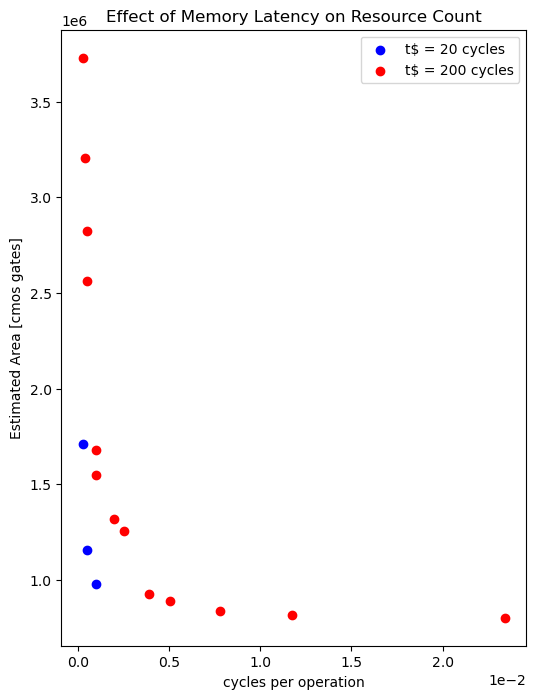

In [12]:
tm20_perf_model = perf_model.copy()
tm200_perf_model = fmodel.init_pm(
    t_mem = np.array([200]),
    l2_cache = np.array([256]),
    vlB = np.array([128, 256, 512])/8,
    vl_ml = np.array([1,2]),
    num_mregs = np.array(range(2,12,2)),
    t_op = np.array([0, 1, 2]),
    width_datapath = np.array([1])
)

tm20_pm_pareto = tm20_perf_model[['ops_cycle','opu_area']]
tm20_mask = paretoset(tm20_pm_pareto, sense=['max', 'min'])

tm200_pm_pareto = tm200_perf_model[['ops_cycle','opu_area']]
tm200_mask = paretoset(tm200_pm_pareto, sense=['max', 'min'])

fig, axs = plt.subplots(1,figsize=(6,8))
axs.set_title('Effect of Memory Latency on Resource Count')
axs.set_xlabel('cycles per operation')
axs.set_ylabel('Estimated Area [cmos gates]')

bw = tm20_perf_model.loc[tm20_mask,'mrf_opi']
ngates = tm20_perf_model.loc[tm20_mask,'opu_area']
opc = tm20_perf_model.loc[tm20_mask,'ops_cycle']
scatter = axs.scatter(1/opc, ngates, color='b', label='t$ = 20 cycles')

bw = tm200_perf_model.loc[tm200_mask,'mrf_opi']
ngates = tm200_perf_model.loc[tm200_mask,'opu_area']
opc = tm200_perf_model.loc[tm200_mask,'ops_cycle']
scatter = axs.scatter(1/opc, ngates, color='r', label='t$ = 200 cycles')

axs.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axs.legend()
tm200_perf_model[tm200_mask]

We can compare these tradeoffs for half-width and full-width MMU datapaths:

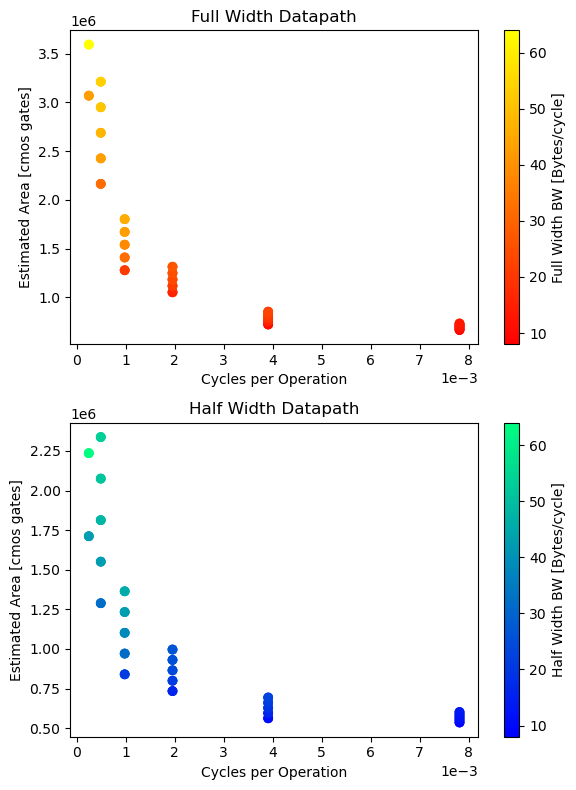

In [13]:
perf_model = fmodel.init_pm(
    vl_ml = np.array([1,2]),
    vlB = np.array([128, 256, 512])/8,
    N = np.array(range(4,64, 8)),
    M = np.array(range(4,64, 8)),
    K = np.array(range(4,64, 8)),
    num_mregs = np.array(range(2,6,2)),
    t_op = np.array([0, 1, 2]),
    width_datapath = np.array([0.5, 1])
)
perf_model_t1 = fmodel.init_pm(
    vl_ml = np.array([1,2]),
    vlB = np.array([128, 256, 512])/8,
    num_mregs = np.array(range(2,12,2)),
    t_op = np.array([0, 1, 2]),
    width_datapath = np.array([1])
)
perf_model_t4 = fmodel.init_pm(
    vl_ml = np.array([1,2]),
    vlB = np.array([128, 256, 512])/8,
    num_mregs = np.array(range(2,12,2)),
    t_op = np.array([0, 1, 2]),
    width_datapath = np.array([0.5])
)
perf_model_t1 = perf_model_t1[perf_model_t1['mrf_opi'] <= 64]
bw = perf_model_t1['mrf_opi']
ngates = perf_model_t1['opu_area']
opc = perf_model_t1['ops_cycle']

perf_model_t4 = perf_model_t4[perf_model_t4['mrf_opi'] <= 64]
bw_t4 = perf_model_t4['mrf_opi']
ngates_t4 = perf_model_t4['opu_area']
opc_t4 = perf_model_t4['ops_cycle']

fig, axs = plt.subplots(2, figsize=(6, 8))
# Plot for full width datapath
axs[0].set_title('Full Width Datapath')
axs[0].set_xlabel('Cycles per Operation')
axs[0].set_ylabel('Estimated Area [cmos gates]')
axs[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
full = axs[0].scatter(1/opc, ngates, c=bw, cmap='autumn', label='full width')
fig.colorbar(full, ax=axs[0], label='Full Width BW [Bytes/cycle]')

# Plot for half width datapath
axs[1].set_title('Half Width Datapath')
axs[1].set_xlabel('Cycles per Operation')
axs[1].set_ylabel('Estimated Area [cmos gates]')
axs[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
half = axs[1].scatter(1/opc_t4, ngates_t4, c=bw_t4, cmap='winter', label='half width')
fig.colorbar(half, ax=axs[1], label='Half Width BW [Bytes/cycle]')
plt.tight_layout()
plt.show()


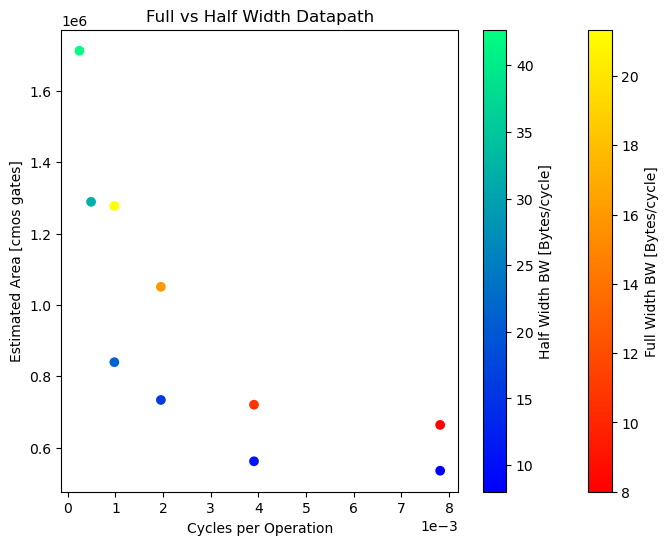

In [14]:
perf_model_t1 = fmodel.init_pm(
    vl_ml = np.array([1,2]),
    vlB = np.array([128, 256, 512])/8,
    num_mregs = np.array(range(2,12,2)),
    t_op = np.array([0, 1, 2]),
    width_datapath = np.array([1])
)
perf_model_t4 = fmodel.init_pm(
    vl_ml = np.array([1,2]),
    vlB = np.array([128, 256, 512])/8,
    num_mregs = np.array(range(2,12,2)),
    t_op = np.array([0, 1, 2]),
    width_datapath = np.array([0.5])
)
perf_model_t1 = perf_model_t1[perf_model_t1['mrf_opi'] <= 64]
perf_model_t1 = perf_model_t1[perf_model_t1['opu_area'] <= 2e6]
perf_model_t1 = perf_model_t1[perf_model_t1['ops_cycle'] >= 1/3.5e-2]

pm_pareto = perf_model_t1[['ops_cycle','opu_area', 'mrf_opi']]
mask = paretoset(pm_pareto, sense=['max', 'min', 'min'])

bw = perf_model_t1.loc[mask,'mrf_opi']
ngates = perf_model_t1.loc[mask,'opu_area']
opc = perf_model_t1.loc[mask,'ops_cycle']

perf_model_t4 = perf_model_t4[perf_model_t4['mrf_opi'] <= 64]
perf_model_t4 = perf_model_t4[perf_model_t4['opu_area'] <= 2e6]
perf_model_t4 = perf_model_t4[perf_model_t4['ops_cycle'] >= 1/3.5e-2]

pm_pareto_t4 = perf_model_t4[['ops_cycle','opu_area', 'mrf_opi']]
mask_t4 = paretoset(pm_pareto_t4, sense=['max', 'min', 'min'])

bw_t4 = perf_model_t4.loc[mask_t4,'mrf_opi']
ngates_t4 = perf_model_t4.loc[mask_t4,'opu_area']
opc_t4 = perf_model_t4.loc[mask_t4,'ops_cycle']

fig, axs = plt.subplots(1,figsize=(8,6))
axs.set_title('Full vs Half Width Datapath')
axs.set_xlabel('Cycles per Operation')
axs.set_ylabel('Estimated Area [cmos gates]')

full = axs.scatter(1/opc, ngates, c=bw, cmap='autumn', label='full width')
fig.colorbar(full, ax=axs, label = 'Full Width BW [Bytes/cycle]')

half = axs.scatter(1/opc_t4, ngates_t4, c=bw_t4, cmap='winter', label='half width')
fig.colorbar(half, ax=axs, label = 'Half Width BW [Bytes/cycle]')
axs.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


In [15]:
perf_model_t4.loc[mask_t4]

t_uk  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath          
8        20    64 64 64 128      1  16.0 1     2         0    4     0.5             424.0   
                                         2     2         0    4     0.5             360.0   
                                    32.0 1     2         0    4     0.5             552.0   
                                         2     2         0    4     0.5             424.0   
                                    64.0 1     2         0    4     0.5             808.0   
                                         2     2         0    4     0.5             552.0   

                                                                                    util  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath         
8        20    64 64 64 128      1  16.0 1     2         0    4     0.5              1.0   
                                         2     2         0    4     0.5              1.0   
                                    32.0 1     2         0    4     0.5              1.0   
                                         2     2         0    4     0.5              1.0   
                                    64.0 1     2         0    4     0.5              1.0   
                                         2     2         0    4     0.5              1.0   

                                                                                    ops_cycle  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath              
8        20    64 64 64 128      1  16.0 1     2         0    4     0.5                 256.0   
                                         2     2         0    4     0.5                 128.0   
                                    32.0 1     2         0    4     0.5                1024.0   
                                         2     2         0    4     0.5                 512.0   
                                    64.0 1     2         0    4     0.5                4096.0   
                                         2     2         0    4     0.5                2048.0   

                                                                                    max_mregs  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath              
8        20    64 64 64 128      1  16.0 1     2         0    4     0.5                   2.0   
                                         2     2         0    4     0.5                   2.0   
                                    32.0 1     2         0    4     0.5                   2.0   
                                         2     2         0    4     0.5                   2.0   
                                    64.0 1     2         0    4     0.5                   2.0   
                                         2     2         0    4     0.5                   2.0   

                                                                                    max_mrf_capacity  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath                     
8        20    64 64 64 128      1  16.0 1     2         0    4     0.5                          4.0   
                                         2     2         0    4     0.5                          2.0   
                                    32.0 1     2         0    4     0.5                         16.0   
                                         2     2         0    4     0.5                          8.0   
                                    64.0 1     2         0    4     0.5                         32.0   
                                         2     2         0    4     0.5                         32.0   

                                                                                    blas_mem_bw  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath                
8        20    64 

In [16]:
perf_model_t1.loc[mask]

t_uk  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath          
8        20    64 64 64 128      1  16.0 1     2         0    4     1               136.0   
                                         2     2         0    4     1               120.0   
                                    32.0 1     2         0    4     1               168.0   
                                         2     2         0    4     1               136.0   

                                                                                    util  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath         
8        20    64 64 64 128      1  16.0 1     2         0    4     1                1.0   
                                         2     2         0    4     1                1.0   
                                    32.0 1     2         0    4     1                1.0   
                                         2     2         0    4     1                1.0   

                                                                                    ops_cycle  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath              
8        20    64 64 64 128      1  16.0 1     2         0    4     1                   256.0   
                                         2     2         0    4     1                   128.0   
                                    32.0 1     2         0    4     1                  1024.0   
                                         2     2         0    4     1                   512.0   

                                                                                    max_mregs  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath              
8        20    64 64 64 128      1  16.0 1     2         0    4     1                     2.0   
                                         2     2         0    4     1                     2.0   
                                    32.0 1     2         0    4     1                     2.0   
                                         2     2         0    4     1                     2.0   

                                                                                    max_mrf_capacity  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath                     
8        20    64 64 64 128      1  16.0 1     2         0    4     1                            4.0   
                                         2     2         0    4     1                            2.0   
                                    32.0 1     2         0    4     1                           16.0   
                                         2     2         0    4     1                            8.0   

                                                                                    blas_mem_bw  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath                
8        20    64 64 64 128      1  16.0 1     2         0    4     1                      16.0   
                                         2     2         0    4     1                       9.6   
                                    32.0 1     2         0    4     1                      48.0   
                                         2     2         0    4     1                      32.0   

                                                                                       mrf_bw  \
databits t_mem M  N  K  l2_cache kl vlB  vl_ml num_mregs t_op widen width_datapath              
8        20    64 64 64 128      1  16.0 1     2         0    4     1               42.666667   
                                         2     2         0    4     1               32.000000   
                                    32.0 1     2         0    4     1               96.000000   
                                         2     2         0    4     1               74.666667   

    